In [1]:
import xarray as xr
import emaremes as mrms

from scipy import stats

file = mrms.download.LOCALPATH / "20240927/PrecipFlag_00.00_20240927-120000.grib2"
assert file.exists()

In [2]:
ds = xr.load_dataset(file, engine="cfgrib", decode_timedelta=False)
ds

<xarray.Dataset> Size: 98MB
Dimensions:         (latitude: 3500, longitude: 7000)
Coordinates:
    time            datetime64[ns] 8B 2024-09-27T12:00:00
    step            float64 8B 0.0
    heightAboveSea  float64 8B 0.0
  * latitude        (latitude) float64 28kB 54.99 54.98 54.98 ... 20.02 20.01
  * longitude       (longitude) float64 56kB 230.0 230.0 230.0 ... 300.0 300.0
    valid_time      datetime64[ns] 8B 2024-09-27T12:00:00
Data variables:
    unknown         (latitude, longitude) float32 98MB -3.0 -3.0 ... -3.0 -3.0
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-03-28T11:02 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
masked = ds.where(ds["unknown"] != -3).where(ds["unknown"] != 0)

In [4]:
extent = mrms.utils.STATE_BOUNDS["NC"]
xclip = masked.loc[extent.as_xr_slice()]

In [5]:
xclip

<xarray.Dataset> Size: 1MB
Dimensions:         (latitude: 295, longitude: 886)
Coordinates:
    time            datetime64[ns] 8B 2024-09-27T12:00:00
    step            float64 8B 0.0
    heightAboveSea  float64 8B 0.0
  * latitude        (latitude) float64 2kB 36.69 36.68 36.67 ... 33.76 33.75
  * longitude       (longitude) float64 7kB 275.6 275.6 275.6 ... 284.4 284.4
    valid_time      datetime64[ns] 8B 2024-09-27T12:00:00
Data variables:
    unknown         (latitude, longitude) float32 1MB 1.0 1.0 1.0 ... nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-03-28T11:02 GRIB to CDM+CF via cfgrib-0.9.1...

In [6]:
coarse = xclip.coarsen(latitude=5, longitude=5, boundary="pad")
coarse

DatasetCoarsen [windows->{'latitude': 5, 'longitude': 5},side->left]

In [8]:
reduced_mean = coarse.mean()
reduced_mean

<xarray.Dataset> Size: 44kB
Dimensions:         (latitude: 59, longitude: 178)
Coordinates:
    time            datetime64[ns] 8B 2024-09-27T12:00:00
    step            float64 8B 0.0
    heightAboveSea  float64 8B 0.0
  * latitude        (latitude) float64 472B 36.67 36.62 36.57 ... 33.82 33.77
  * longitude       (longitude) float64 1kB 275.6 275.7 275.7 ... 284.4 284.4
    valid_time      datetime64[ns] 8B 2024-09-27T12:00:00
Data variables:
    unknown         (latitude, longitude) float32 42kB 1.0 1.0 1.0 ... nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-03-28T11:02 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
reduced_mode = coarse.reduce(lambda x, axis: stats.mode(x, axis=axis).mode)
reduced_mode

<xarray.Dataset> Size: 86kB
Dimensions:         (latitude: 59, longitude: 178)
Coordinates:
    time            datetime64[ns] 8B 2024-09-27T12:00:00
    step            float64 8B 0.0
    heightAboveSea  float64 8B 0.0
  * latitude        (latitude) float64 472B 36.67 36.62 36.57 ... 33.82 33.77
  * longitude       (longitude) float64 1kB 275.6 275.7 275.7 ... 284.4 284.4
    valid_time      datetime64[ns] 8B 2024-09-27T12:00:00
Data variables:
    unknown         (latitude, longitude) float64 84kB 1.0 1.0 1.0 ... nan nan
Attributes:
    GRIB_edition:            2
    GRIB_centre:             161
    GRIB_centreDescription:  US NOAA Office of Oceanic and Atmospheric Research
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US NOAA Office of Oceanic and Atmospheric Research
    history:                 2025-03-28T11:02 GRIB to CDM+CF via cfgrib-0.9.1...

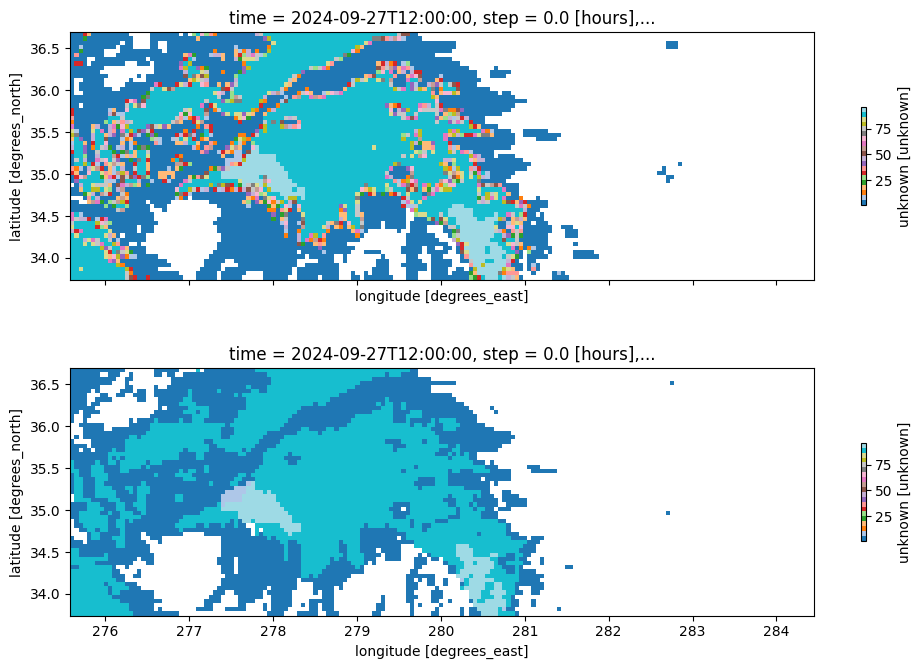

In [18]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, sharey=True)
ax1.set_aspect("equal")
ax2.set_aspect("equal")
reduced_mean["unknown"].plot(ax=ax1, cbar_kwargs=dict(shrink=0.35), cmap="tab20")
reduced_mode["unknown"].plot(ax=ax2, cbar_kwargs=dict(shrink=0.35), cmap="tab20")
plt.show()
